In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    


c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


torch.Size([1, 10])
(68422, 10)
(68422, 4)
   front_thickness  tail_thickness  eyebrow_length  curve_strength
0        -1.341891       -2.294163       -0.151078        1.498851
1         0.412092       -0.207029       -0.140640       -1.071618
2        -0.312914       -0.662711       -0.626522        1.513978
3        -0.743297       -2.241306       -0.443991        0.626253
4        -0.654522       -0.304597       -0.240360       -0.529442


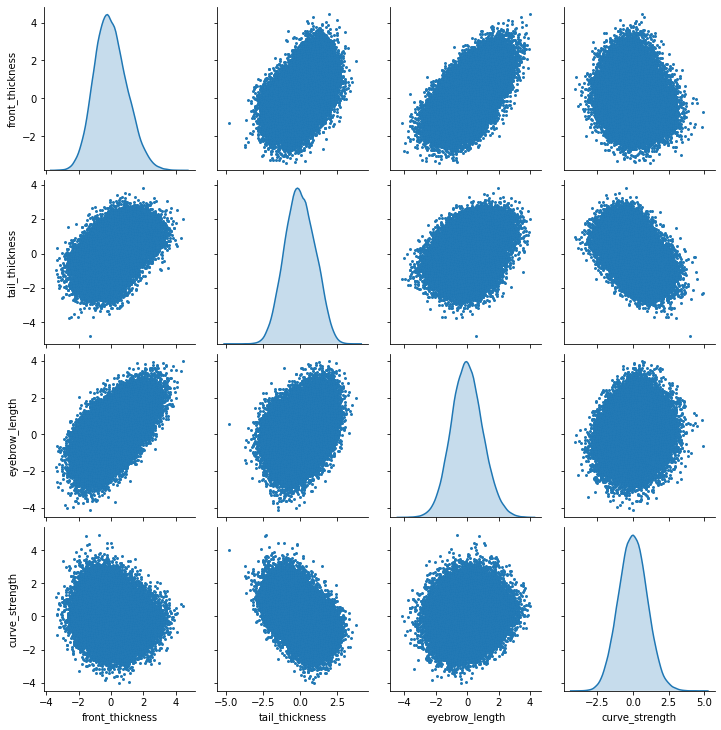

In [9]:
shape_path = '../datasets/FFHQ/raw_bfm_shape/{}.npy'
color_path = '../datasets/FFHQ/raw_bfm_color/{}.npy'


ffhq_meanshape = np.load('./ffhq_meanshape.npy')
file_indices = np.load('./cache/shape_latents/file_indices.npy')

part_name = 'S_eyebrows'


""" Load data """
meanshape_latents = np.load('./cache/meanshape_latents/{}.npy'.format(part_name))
meanshape_latents = torch.from_numpy(meanshape_latents).to(device)
print(meanshape_latents.shape)


latents = np.load('./cache/shape_latents/{}.npy'.format(part_name))
print(latents.shape)

measurements = np.load('./cache/measurements/{}.npy'.format(part_name))
print(measurements.shape)



"""
Min-max normalization
Pros. & Cons.
Guarantees all features will have the exact same scale but does not handle outliers well.
----------------------
normalize to -1 ~ +1
"""
"""
for dim in range(measurements.shape[1]):
    min_ = np.min(measurements[:,dim])
    max_ = np.max(measurements[:,dim])
    measurements[:,dim] = (measurements[:,dim] - min_) / (max_ - min_) # 0 ~ 1
    measurements[:,dim] *= 2 # 0 ~ 2
    measurements[:,dim] -= 1 # -1 ~ 1
""" 
    
"""
Z-score standardization
Pros. & Cons.
Handles outliers, but does not produce normalized data with the exact same scale.
----------------------
0 mean, unit variance
"""
#"""
std = []
for dim in range(measurements.shape[1]):
    mean_ = np.mean(measurements[:,dim])
    std_ = np.std(measurements[:,dim])
    std.append(std_)
    measurements[:,dim] = (measurements[:,dim] - mean_) / std_ # 0 mean, unit variance
    ##measurements[:,dim] = (measurements[:,dim] - mean_) # 0 mean
#"""
    

#########################################################
## Comments:
##
##  I found using z-scoer is much better than min-max
#########################################################

import seaborn as sns
import pandas as pd

measurement_names = [
    'front_thickness',
    'tail_thickness',
    'eyebrow_length',
    'curve_strength',
]
    


d = {
    measurement_names[0]: measurements[:, 0],
    measurement_names[1]: measurements[:, 1],
    measurement_names[2]: measurements[:, 2],
    measurement_names[3]: measurements[:, 3],
    #measurement_names[4]: measurements[:, 4]
}

df = pd.DataFrame(data=d)
print(df.head())

_ = sns.pairplot(df, 
                 plot_kws=dict(marker=".", linewidth=0.01), 
                 diag_kind="kde")




In [10]:
std

[0.007940113808201156,
 0.0024313051271882147,
 0.014412436918214663,
 0.005232312973642423]

In [11]:
sigma = np.array(measurements.std(axis=0), dtype=np.float32)
sigma

array([1., 1., 1., 1.], dtype=float32)

In [12]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


(4, 68422)
(68422, 10)
(4, 10)


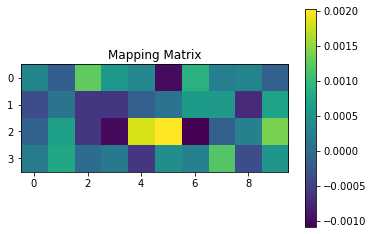

In [14]:
""" 
Solve the linear system via pseudo inverse 
-------------------------------------------
Assume:
                   FM = dZ,
where
     F : measurement matrix of size n x 5
     M : mapping matrix of size 5 x 10
     dZ: matrix of latent offsets of size n x 10
-------------------------------------------
Objective is to find the pseudo inverse of F
to solve the linear system:
                 M = inv(F)dZ
"""
##############
## Find inv(F)
measurements_inv = np.linalg.pinv(measurements) # Moore-Penrose Pseudo Inverse
print(measurements_inv.shape)

##############
## Compute dZ
delta_latents = latents - meanshape_latents.detach().cpu().numpy()
print(delta_latents.shape)

####################################
# Compute the mapping M: shape [6 x 10]
M = measurements_inv @ delta_latents
M = np.array(M, dtype=np.float32)
print(M.shape)
plt.imshow(M)
plt.title('Mapping Matrix')
plt.colorbar()

np.save('./cache/mappings/{}.npy'.format(part_name), M)


M = torch.from_numpy(M).to(device)
S = torch.from_numpy(sigma).to(device)
def mapping(M, f):
    # input (torch tensor):   measurement with size [1, 4]
    # output (torch tensor):  latent offset with size [1, 10]
    #return (f * S) @ M
    return f  @ M
        

In [16]:
class Decoder(nn.Module):
    """part decoder"""
    def __init__(self, latent_dim, n_vert):
        super(Decoder, self).__init__()
        self.n_vert = n_vert
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 3*self.n_vert)
        
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_ = self.fc3(h)
        return torch.reshape(x_, [-1, self.n_vert, 3])
    
part_decoder = Decoder(latent_dim=10, n_vert=len(part_vertices[part_name])).to(device)
part_decoder.load_state_dict(torch.load('../../3dmm_local_editing_prototype_3_new/saved_models/part_decoders/{}'.format(part_name)))
print('decoder model on CUDA: ', next(part_decoder.parameters()).is_cuda) # True



decoder model on CUDA:  True


In [17]:

def o3d_render(V, T, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    if T is not None:
        o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
        
    if T is None:
        o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    vis.add_geometry(o3d_mesh)
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image


part_Faces = []
for tri_face in bfm['tri']:
    flag = True
    for v in tri_face:
        if v not in part_vertices[part_name]:
            flag = False
            break
    if flag:
        part_Faces.append(tri_face)
part_Faces = np.array(part_Faces) ## for BFM_model



front_thickness


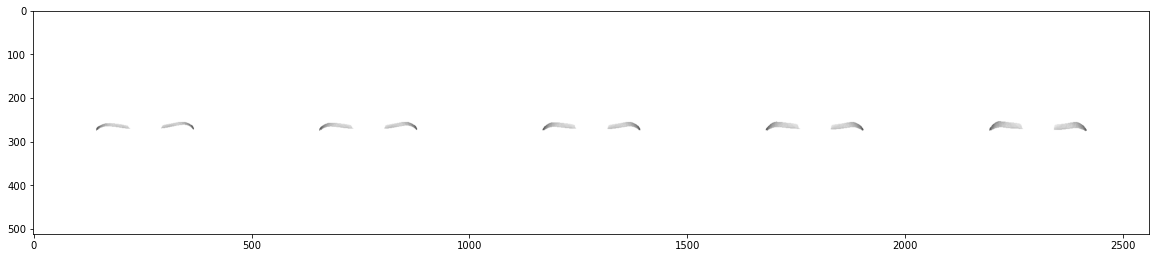

tail_thickness


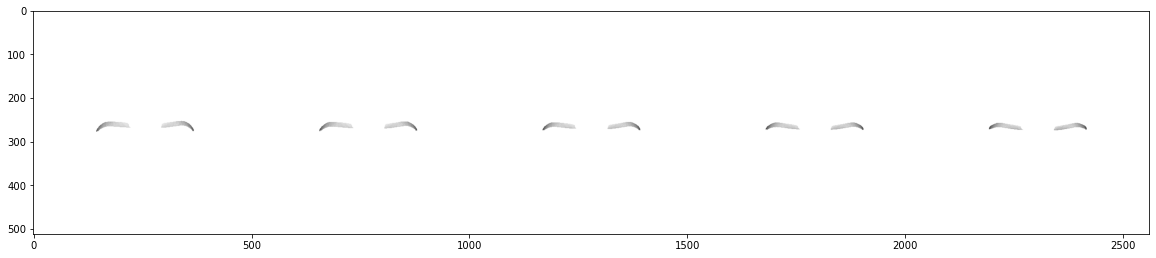

eyebrow_length


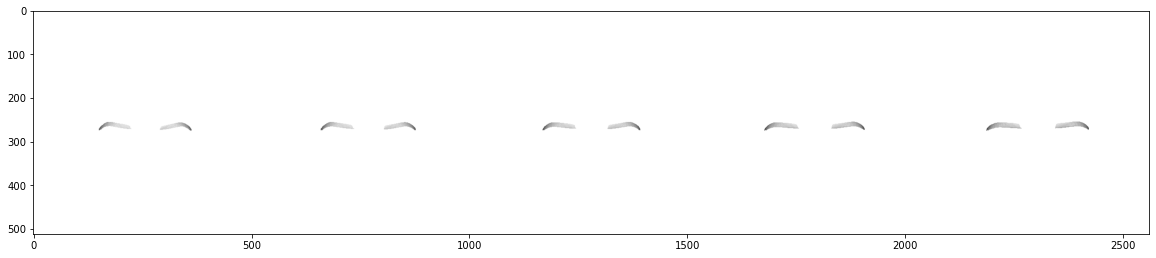

curve_strength


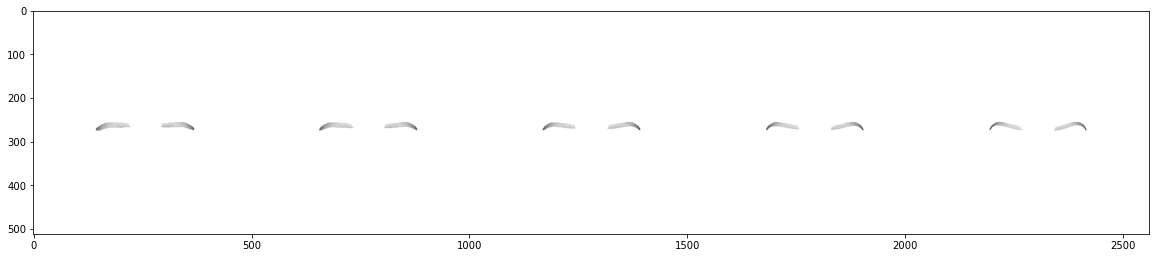

In [26]:
def plot_reconstructed_1dof(mapping, part_decoder, part_V, part_Faces, measurement_dim, r0=(-0.1, 0.1), dim=0, n=3):
    w = 512
    img = np.zeros((w, n*w, 3))
    for j, x in enumerate(np.linspace(*r0, n)):
        f = torch.zeros([1, measurement_dim]).to(device)
        f[0,dim] = x
        
        latent_offset = mapping(M, f).to(device)
        new_latent = meanshape_latents + latent_offset
        
        new_shape = part_decoder(new_latent)[0].detach().cpu().numpy()

        V = np.zeros([35709, 3], dtype=np.float32)
        V = ffhq_meanshape[0]
        V[part_V,:] = new_shape

        _, image = o3d_render(V, None, part_Faces)
        
        img[0:w, j*w:(j+1)*w] = image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()
    

for dimension in range(len(measurement_names)):
    print(measurement_names[dimension])
    plot_reconstructed_1dof(mapping, part_decoder, part_vertices[part_name], part_Faces,
                            measurement_dim=len(measurement_names), r0=(-3, 3), dim=dimension, n=5)

In [18]:
from ipywidgets import interact
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
import math

"""
Interactive Editor Demo #1 
---------------------------
Edit on mean shape
"""


def rotation_matrix(yaw):
    ## 0 <= yaw <= 3.14 
    Ry = np.array([[math.cos(yaw), 0, math.sin(yaw)],
                   [0, 1, 0],
                   [-math.sin(yaw), 0, math.cos(yaw)]],)
    return Ry

## the control range
#lb_ = -0.8
#ub_ = 0.8
lb_ = -4
ub_ = 4


@interact(front_thickness  =FloatSlider(min=lb_, max=ub_, step=0.4), 
          tail_thickness       =FloatSlider(min=lb_, max=ub_, step=0.4),
          eyebrow_length =FloatSlider(min=lb_, max=ub_, step=0.4),
          curve_strength =FloatSlider(min=lb_, max=ub_, step=0.4),
          rotate    =FloatSlider(min=0, max=3.14/2, step=0.1))
def nose_editor(front_thickness, 
                tail_thickness, 
                eyebrow_length, 
                curve_strength,
                rotate):
    
    # measurement vector
    f = torch.tensor([[front_thickness, 
                       tail_thickness, 
                       eyebrow_length, 
                       curve_strength]]).to(device)
        
    # predict latent offset
    latent_offset = mapping(M, f).to(device)

    # generate new latent vector
    new_latent = meanshape_latents + latent_offset
        
    # generate new shape
    new_shape = part_decoder(new_latent)[0].detach().cpu().numpy()
    
    # rotate the shape
    new_shape_rotated = new_shape @ rotation_matrix(rotate)

    # visualize new shape
    V = np.zeros([35709, 3], dtype=np.float32)
    V = ffhq_meanshape[0]
    V[part_vertices[part_name],:] = new_shape_rotated
    _, image = o3d_render(V, None, part_Faces)
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.imshow(latent_offset.detach().cpu().numpy().transpose())
    plt.subplot(1,2,2)
    plt.imshow(image)
    
    

interactive(children=(FloatSlider(value=0.0, description='front_thickness', max=4.0, min=-4.0, step=0.4), Floa…